In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

import data
import train
import plot
import torch

/home/maarten/Documents/masterthesis/supervised


In [24]:
num_clusters = 3

files = [f'../clusterlabeled-{num_clusters}/1800{i}.xml' for i in [1, 2, 3, 4, 5]]
dataset = data.GermanDatasetInMemory(files, num_clusters, 500, 1500, 3, 0)

Creating dictionary: 100%|██████████| 5/5 [00:00<00:00,  7.29it/s]
685it [00:04, 149.06it/s]                         


In [25]:
traindata, testdata = dataset.split(0.3)

params = train.CNNParams(
    embed_size=300,
    dropout=0.50,
    epochs=50,
    num_filters=100
)

optimizer = lambda params: torch.optim.Adadelta(params, weight_decay=0.001)
model, losses = train.setup_and_train(params, with_labels=False, dataset=traindata,
                                      epochs=params.epochs, batch_size=50, optim_fn=optimizer)
label_model, label_losses = train.setup_and_train(params, with_labels=True,
                                                  dataset=traindata, epochs=params.epochs,
                                                  batch_size=50, optim_fn=optimizer)

Training: 100%|██████████| 50/50 [00:37<00:00,  1.35it/s, loss=0.346, Δloss=0.000237]


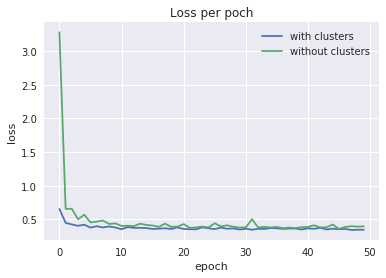

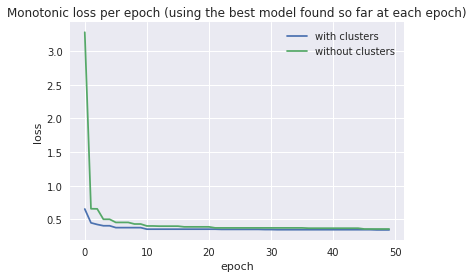

In [26]:
plot.plot({'with clusters': label_losses, 'without clusters': losses}, False, 'Loss per poch')
plot.plt.figure()
plot.plot({'with clusters': label_losses, 'without clusters': losses}, True,
          'Monotonic loss per epoch (using the best model found so far at each epoch)')

In [27]:
print('Without clusters:')
train.evaluate_clf(model, data.get_iterator(testdata, [40]))
print('With clusters:')
train.evaluate_clf(label_model, data.get_iterator(testdata, [40]));

Without clusters:

----------------  --------
f1                0.825581
Speech recall     0.904459
Speech precision  0.759358
----------------  --------
With clusters:

----------------  --------
f1                0.895623
Speech recall     0.847134
Speech precision  0.95
----------------  --------


In [28]:
nolabel_pr = train.pr_curve(model, data.get_iterator(testdata, [40]))
label_pr = train.pr_curve(label_model, data.get_iterator(testdata, [40]));

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


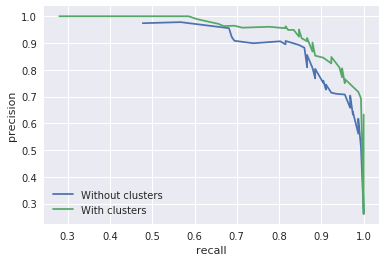

In [29]:
# filter degenerate values when the recall is 0, and sort by recall
nolabel_pr = sorted([(p, r) for p, r in nolabel_pr if r != 0], key=lambda x: x[1])
label_pr = sorted([(p, r) for p, r in label_pr if r != 0], key=lambda x: x[1])

import matplotlib.pyplot as plt
plt.plot([r for p, r in nolabel_pr], [p for p, r in nolabel_pr], label='Without clusters')
plt.plot([r for p, r in label_pr], [p for p, r in label_pr], label='With clusters')
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision');

In [36]:
import os
files = os.listdir(f'../testing_data_older-{num_clusters}/')
paths = [f'../testing_data_older-{num_clusters}/' + f for f in files]
old_data = data.GermanDatasetInMemory(paths, num_clusters, 10000, 10000, 3, 0, vocab=traindata.vocab)

  9%|▉         | 875/10000 [00:07<01:13, 123.75it/s]


In [37]:
print('Without clusters:')
train.evaluate_clf(model, data.get_iterator(old_data, [40]))
print('With clusters:')
train.evaluate_clf(label_model, data.get_iterator(old_data, [40]));

Without clusters:

----------------  --------
f1                0.573945
Speech recall     0.707429
Speech precision  0.482839
----------------  --------
With clusters:

----------------  --------
f1                0.624404
Speech recall     0.523429
Speech precision  0.773649
----------------  --------
